# Top 50 Cities Data

In [2]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima

In [4]:
top_50_df = pd.read_csv('../../Data/Cleaned/top_50_us_city_temp.csv',
                            parse_dates=['dt'],
                            index_col=['dt'])
top_50_df

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1900-02-01,2.771,0.839,Albuquerque,United States,34.56N,107.03W
1900-03-01,7.990,0.384,Albuquerque,United States,34.56N,107.03W
1900-04-01,8.955,0.611,Albuquerque,United States,34.56N,107.03W
1900-05-01,16.238,0.401,Albuquerque,United States,34.56N,107.03W
1900-06-01,21.485,0.331,Albuquerque,United States,34.56N,107.03W
...,...,...,...,...,...,...
2013-05-01,18.230,0.153,Wichita,United States,37.78N,97.63W
2013-06-01,25.154,0.171,Wichita,United States,37.78N,97.63W
2013-07-01,26.115,0.261,Wichita,United States,37.78N,97.63W


In [8]:
top_50_df.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude'],
      dtype='object')

# Global Differencing 

Global differencing of our data likely isn't very useful. We are doing this on a per city basis so I plan to split the dataframe by city after doing this. 

<Axes: xlabel='dt'>

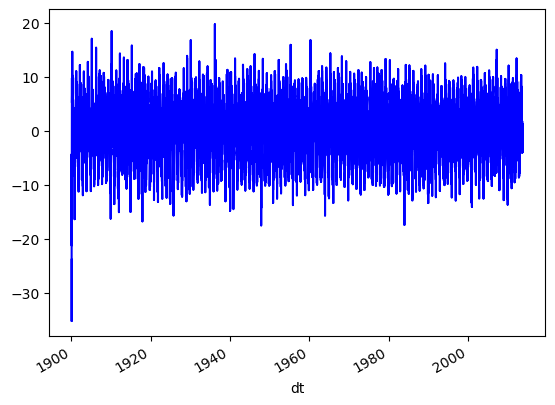

In [26]:
global_first_diff_df = top_50_df['AverageTemperature'].diff().dropna()
global_first_diff_df.plot(color='blue')

In [27]:
X = global_first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -42.254708
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [ ]:
# Our ADF is well below the critical values and our p-value is 0, so we should conclude out data is stationary. 

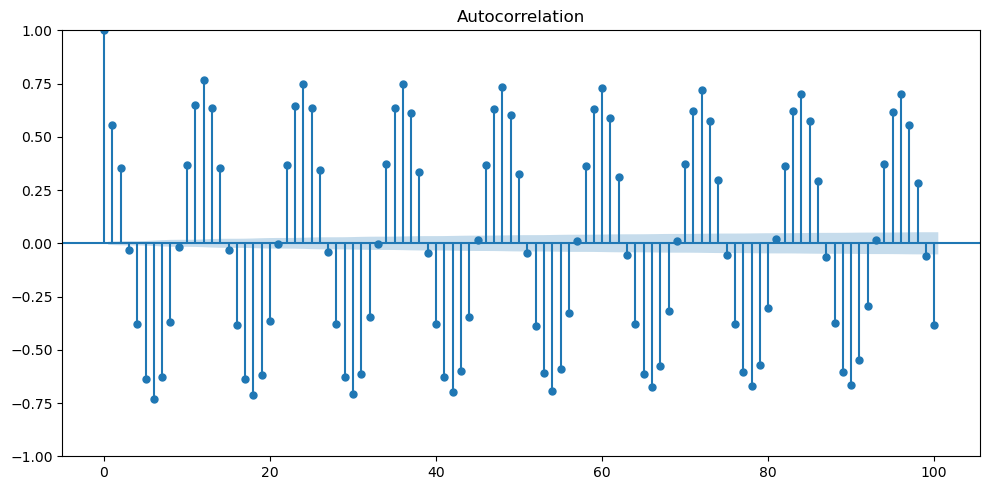

In [19]:
# autocorrelation plot of the first differenced dataset
fig = plot_acf(global_first_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

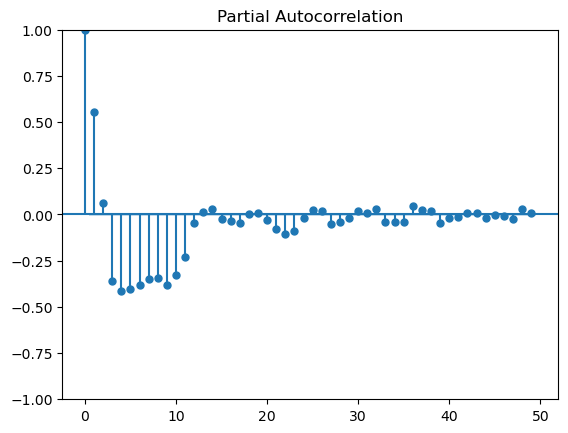

In [20]:
#plot PACF of the differenced time series.
plot_pacf(global_first_diff_df)
plt.show()

<Axes: xlabel='dt'>

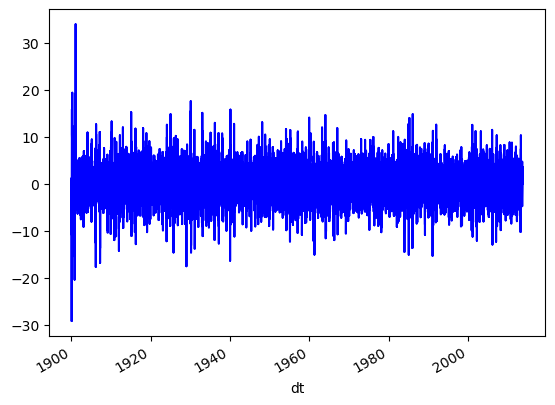

In [13]:
global_seasonal_diff_df = global_first_diff_df.diff(12).dropna()
global_seasonal_diff_df.plot(color = 'blue')

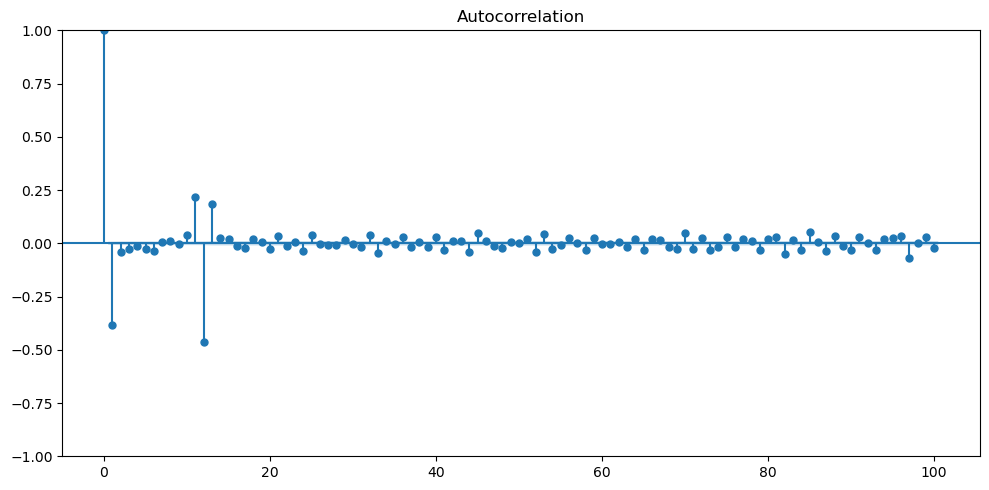

In [14]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(global_seasonal_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

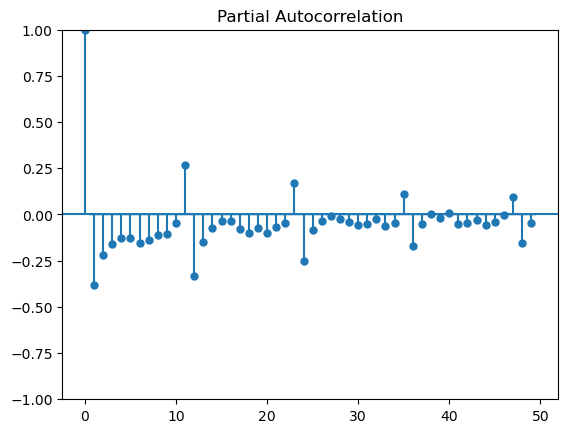

In [15]:
#plot PACF of the differenced time series.
plot_pacf(global_seasonal_diff_df)
plt.show()

In [16]:
X = global_seasonal_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -63.082100
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


# Per City Differencing

In [28]:
top_50_df['City'].unique()

array(['Albuquerque', 'Arlington', 'Atlanta', 'Austin', 'Bakersfield',
       'Baltimore', 'Boston', 'Charlotte', 'Chicago', 'Colorado Springs',
       'Columbus', 'Dallas', 'Denver', 'Detroit', 'El Paso', 'Fort Worth',
       'Fresno', 'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City',
       'Las Vegas', 'Long Beach', 'Los Angeles', 'Louisville', 'Memphis',
       'Mesa', 'Miami', 'Milwaukee', 'Minneapolis', 'Nashville',
       'New York', 'Oakland', 'Oklahoma City', 'Omaha', 'Philadelphia',
       'Phoenix', 'Portland', 'Raleigh', 'Sacramento', 'San Antonio',
       'San Diego', 'San Francisco', 'San Jose', 'Seattle', 'Tucson',
       'Tulsa', 'Virginia Beach', 'Washington', 'Wichita'], dtype=object)

In [29]:
grouped_by_city = top_50_df.groupby('City')

In [31]:
# Display a sample of each group
for city, city_group in grouped_by_city:
    print(f"City: {city}")
    print(city_group.head())  # Adjust the number of rows displayed as needed
    print("\n" + "="*30 + "\n")  # Add a separator for clarity


City: Albuquerque
            AverageTemperature  AverageTemperatureUncertainty         City  \
dt                                                                           
1900-02-01               2.771                          0.839  Albuquerque   
1900-03-01               7.990                          0.384  Albuquerque   
1900-04-01               8.955                          0.611  Albuquerque   
1900-05-01              16.238                          0.401  Albuquerque   
1900-06-01              21.485                          0.331  Albuquerque   

                  Country Latitude Longitude  
dt                                            
1900-02-01  United States   34.56N   107.03W  
1900-03-01  United States   34.56N   107.03W  
1900-04-01  United States   34.56N   107.03W  
1900-05-01  United States   34.56N   107.03W  
1900-06-01  United States   34.56N   107.03W  


City: Arlington
            AverageTemperature  AverageTemperatureUncertainty       City  \
dt          

In [35]:

differenced_data = pd.DataFrame()

# Iterate over each group (city) and difference the 'AverageTemperature' column
for city, city_group in grouped_by_city:
    city_group['AverageTemperatureDiff'] = city_group['AverageTemperature'].diff()
    differenced_data = pd.concat([differenced_data, city_group])

# Drop NaN values resulting from differencing
differenced_data = differenced_data.dropna()


In [36]:
# Assuming 'differenced_data' is your DataFrame with differenced data
grouped_by_city_diff = differenced_data.groupby('City')

# Display a sample of each group with differenced data
for city, city_group_diff in grouped_by_city_diff:
    print(f"City: {city}")
    print(city_group_diff.head())  # Adjust the number of rows displayed as needed
    print("\n" + "="*30 + "\n")  # Add a separator for clarity


City: Albuquerque
            AverageTemperature  AverageTemperatureUncertainty         City  \
dt                                                                           
1900-03-01               7.990                          0.384  Albuquerque   
1900-04-01               8.955                          0.611  Albuquerque   
1900-05-01              16.238                          0.401  Albuquerque   
1900-06-01              21.485                          0.331  Albuquerque   
1900-07-01              23.562                          0.685  Albuquerque   

                  Country Latitude Longitude  AverageTemperatureDiff  
dt                                                                    
1900-03-01  United States   34.56N   107.03W                   5.219  
1900-04-01  United States   34.56N   107.03W                   0.965  
1900-05-01  United States   34.56N   107.03W                   7.283  
1900-06-01  United States   34.56N   107.03W                   5.247  
1900-07-0

In [42]:
grouped_by_city_diff.columns()


AttributeError: 'DataFrameGroupBy' object has no attribute 'columns'

# Auto ARIMA
Using the auto ARIMA to see which models would be best to run.

In [22]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(top_50_df, test_size=12, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 70916
No. of testing examples: 12


In [23]:
train_data

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
dt,,,,,,
1900-02-01,2.771,0.839,Albuquerque,United States,34.56N,107.03W
1900-03-01,7.990,0.384,Albuquerque,United States,34.56N,107.03W
1900-04-01,8.955,0.611,Albuquerque,United States,34.56N,107.03W
1900-05-01,16.238,0.401,Albuquerque,United States,34.56N,107.03W
1900-06-01,21.485,0.331,Albuquerque,United States,34.56N,107.03W
...,...,...,...,...,...,...
2012-05-01,22.245,0.221,Wichita,United States,37.78N,97.63W
2012-06-01,25.901,0.426,Wichita,United States,37.78N,97.63W
2012-07-01,30.788,0.388,Wichita,United States,37.78N,97.63W
